In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from torch.autograd import Variable
from torch.utils.data import DataLoader
from generation.train.autoencoder import AutoEncoder, run_train, generate_new_signal
from generation.data.data_simulation import Nakagami
from generation.data.dataset_pytorch import SignalsDataset
from generation.train.vanila_gan import run_train, generate_new_signal

In [2]:
# Data params
SAMPLE_SIZE = 1000
Q_LOWER = 0.001
Q_UPPER = 0.999
NU_MIN = 0.9
NU_MAX = 1.2
NU_STEP = 0.0001


nakagami = Nakagami(SAMPLE_SIZE, Q_LOWER, Q_UPPER)
nu_values = np.arange(NU_MIN, NU_MAX, NU_STEP)
data = nakagami.get_nakagami_data(nu_values)

In [3]:
LATENT_DIM = 100
BATCH_SIZE = 128
NUM_EPOCHS = 10
LEARNING_RATE = 1e-3
PRINT_EACH = 1
VERBOSE = 1
NO_SAVE = True


dataset = SignalsDataset(data)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [4]:
generator = run_train(dataloader, \
          latent_dim=LATENT_DIM, \
          sample_size=SAMPLE_SIZE, \
          learning_rate=LEARNING_RATE, \
          num_epochs=NUM_EPOCHS, \
          batch_size=BATCH_SIZE, \
          print_each=PRINT_EACH, \
          verbose=VERBOSE, \
          no_save=NO_SAVE)

epoch-0; D_loss: 1.576926827430725; G_loss: 0.384091317653656
epoch-1; D_loss: 1.0947004556655884; G_loss: 0.4144279956817627
epoch-2; D_loss: 0.047595299780368805; G_loss: 3.081474542617798
epoch-3; D_loss: 0.11814887821674347; G_loss: 2.5775020122528076
epoch-4; D_loss: 0.06578382849693298; G_loss: 2.786473035812378
epoch-5; D_loss: 3.5124862733937334e-06; G_loss: 12.56619930267334
epoch-6; D_loss: 0.3406336307525635; G_loss: 1.2457752227783203
epoch-7; D_loss: 0.029378263279795647; G_loss: 6.2359442710876465
epoch-8; D_loss: 0.0003093108825851232; G_loss: 14.169035911560059
epoch-9; D_loss: 0.026303153485059738; G_loss: 6.23226261138916


In [5]:
signal = generate_new_signal(generator)

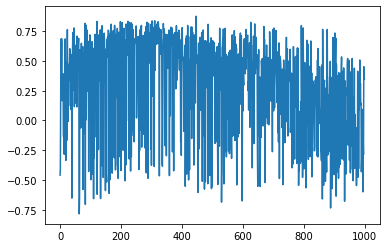

In [7]:
plt.plot(signal)
plt.show()